In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import html
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer



## Step 1: Load the Data

We load the customer review dataset using `pandas`.  
If the file contains special characters (e.g., German umlauts), we use `latin1` encoding.


In [80]:
df = pd.read_csv("CustomerFeedback_reviews.csv", encoding='latin1', sep=';', engine='python')
df.head()
df.columns

Index(['Review Number', 'App Name', 'App Store', 'App', 'Store', 'App ID',
       'Country', 'Version', 'Rating', 'Date', 'Author', 'Subject',
       'Review ID', 'Body', 'Translated Subject', 'Translated Body',
       'Sentiment', 'Device', 'Language', 'OS Version', 'Reply URL', 'Topics',
       'Custom Topics', 'Tags', 'Label1', 'Label2', 'Label3', 'Label4',
       'Product Category 1', 'Product Category 2', 'Product Category 3',
       'Product', 'Product Code', 'Error Code', 'Notes', 'HC function',
       'Unnamed: 36', 'Dish Care', 'Laundry Care', 'Cooking', 'PCP', 'Cooling',
       'Review-ID from AIM', 'Unnamed: 43', 'Unnamed: 44'],
      dtype='object')

In [81]:
print(df.shape)
df.head()

(16833, 45)


,Review Number,App Name,App Store,App,Store,App ID,Country,Version,Rating,Date,...,HC function,Unnamed: 36,Dish Care,Laundry Care,Cooking,PCP,Cooling,Review-ID from AIM,Unnamed: 43,Unnamed: 44
0,1,Home Connect,Google Play,Home Connect,Google Play,com.bshg.homeconnect.android.release,English,7.1.0,1,01.01.2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Home Connect,Google Play,Home Connect,Google Play,com.bshg.homeconnect.android.release,Polish,7.1.0,2,01.01.2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Home Connect,Google Play,Home Connect,Google Play,com.bshg.homeconnect.android.release,English,7.1.0,1,01.01.2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Home Connect,Google Play,Home Connect,Google Play,com.bshg.homeconnect.android.release,German,NaN,1,01.01.2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Home Connect App,iOS,Home Connect App,iOS,901397789,United Arab Emirates,7.1.0,5,01.01.2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df[['Label1', 'Label2', 'Label3', 'Label4']].head(10)


,Label1,Label2,Label3,Label4
0,Sporadic connection losses,NaN,NaN,NaN
1,Connection speed,NaN,NaN,NaN
2,App reliability,Pairing,NaN,NaN
3,Pairing,NaN,NaN,NaN
4,Spam,NaN,NaN,NaN
5,Sporadic connection losses,NaN,NaN,NaN
6,Remote Start/Control,NaN,NaN,NaN
7,App reliability,Too many ads / wrong ads,NaN,NaN
8,Remote Start/Control,NaN,NaN,NaN
9,App functions,NaN,NaN,NaN


In [83]:
coloumns_to_keep = columns_to_keep = [
    'Rating', 'Sentiment', 'Body', 'Translated Body',
    'Label1', 'Label2', 'Label3', 'Label4',
    'Product Category 1', 'Product Category 2', 'Product Category 3',
    'Product', 'Product Code', 'Error Code', 'HC function'
]
df = df[columns_to_keep]


 ## Use Translated Body if available, otherwise use Body

In [84]:
def get_text(row):
    if pd.notnull(row['Translated Body']) and row['Translated Body'].strip() != '':
        return row['Translated Body']
    else:
        return row['Body']

df['text_for_model'] = df.apply(get_text, axis=1)


In [85]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text)      # remove extra spaces
    return text.strip()

df['clean_text'] = df['text_for_model'].apply(clean_text)


## Drop rows with no text at all

In [86]:
df = df.dropna(subset=['clean_text'])
df = df[df['clean_text'].str.strip() != '']


## Full  text cleaning pipeline
Lowercase

Remove HTML, numbers, punctuation, emojis

Remove short words

Remove stopwords (but keep “not”!)

Lemmatize using NLTK

In [97]:
# Set up tools
lemmatizer = WordNetLemmatizer()
stopwords = ENGLISH_STOP_WORDS - {"not", "no", "never"}

# Text cleaning pipeline
def clean_pipeline(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)           # Remove HTML tags
    text = re.sub(r'[^\w\s]', ' ', text)         # Remove punctuation
    text = re.sub(r'\d+', ' ', text)             # Remove numbers
    text = re.sub(r'\b[a-z]{1,2}\b', '', text)   # Remove short words (1–2 letters)
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra spaces
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
    return ' '.join(tokens)

# Choose best text source
def get_best_text(row):
    if pd.notnull(row.get('Translated Body')) and row['Translated Body'].strip():
        return row['Translated Body']
    return row.get('Body', "")

# Apply text selection and cleaning
df['text_for_model'] = df.apply(get_best_text, axis=1)
df['clean_text'] = df['text_for_model'].apply(clean_pipeline)


## Full label cleaning pipeline


In [88]:
# Step 1: Standardize label text format
df['Label1'] = df['Label1'].astype(str).str.lower().str.strip()

# Step 2: Convert "nan" strings back to actual NaN
df['Label1'] = df['Label1'].replace('nan', np.nan)

# Step 3: Drop rows with missing Label1
df = df.dropna(subset=['Label1'])

# Step 4: Count how often each label appears
label_counts = df['Label1'].value_counts()

# Step 5: Drop or group rare labels
# OPTION 1: DROP rare labels (fewer than 10 examples)
rare_labels = label_counts[label_counts < 10].index
df = df[~df['Label1'].isin(rare_labels)]

# OPTION 2: GROUP rare labels as 'other' instead of dropping
# df['Label1'] = df['Label1'].apply(lambda x: x if x in label_counts[label_counts >= 10] else 'other')

# Step 6: Preview cleaned label values
print("Cleaned label distribution:\n")
print(df['Label1'].value_counts())

Cleaned label distribution:

Label1
various                             3121
sporadic connection losses          2347
pairing                             1495
usability                           1220
login                               1004
app functions                        925
app reliability                      751
app availability                     732
remote start/control                 686
push notification                    603
connection other                     573
connection losses after update       490
terms and conditions                 341
improvement ideas                    303
registration                         303
feature shutdown                     252
3rd party                            196
device functions                     170
language                             153
app crash                            150
unclear                              148
customer service                     111
too many ads / wrong ads             108
recipes              

In [89]:
label_cols = ['Label1', 'Label2', 'Label3', 'Label4']

# Clean text formatting
for col in label_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()
    df[col] = df[col].replace(['nan', '0.0', 'none', '', 'na'], np.nan)

# Combine into one multi-label list
def combine_labels(row):
    return [lbl for lbl in [row['Label1'], row['Label2'], row['Label3'], row['Label4']] if pd.notnull(lbl)]

df['multi_labels'] = df.apply(combine_labels, axis=1)

# Drop rows with no labels
df = df[df['multi_labels'].map(len) > 0]


In [90]:
all_labels = df['multi_labels'].explode()
label_counts = Counter(all_labels)

pd.Series(label_counts).sort_values(ascending=False).head(30)


various                             3146
sporadic connection losses          2486
pairing                             1629
usability                           1464
login                               1122
app functions                       1104
app reliability                      901
remote start/control                 847
app availability                     757
push notification                    725
connection other                     654
connection losses after update       512
improvement ideas                    487
terms and conditions                 411
registration                         330
customer service                     324
3rd party                            273
feature shutdown                     267
device functions                     227
language                             187
app crash                            175
too many ads / wrong ads             174
unclear                              148
recipes                              127
connection speed

In [91]:

mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df['multi_labels'])

# Save label names
label_classes = mlb.classes_

# Optionally add to DataFrame
df_labels = pd.DataFrame(label_matrix, columns=label_classes, index=df.index)


In [92]:
print(f"Total unique labels: {len(label_classes)}")
print(label_classes)


Total unique labels: 37
['3rd party' 'app availability' 'app compatibility' 'app crash'
 'app functions' 'app installation' 'app performance' 'app reliability'
 'app start' 'barrier free use' 'connection losses after update'
 'connection other' 'connection speed' 'customer service'
 'device functions' 'feature shutdown' 'firmware update'
 'improvement ideas' 'language' 'login' 'pairing' 'password reset'
 'post update functionality issues' 'price performance' 'program download'
 'push notification' 'recipes' 'registration' 'remote start/control'
 'spam' 'sporadic connection losses' 'terms and conditions'
 'too many ads / wrong ads' 'unclear' 'usability' 'various' 'watch']


<Axes: title={'center': 'Most Frequent Labels'}>

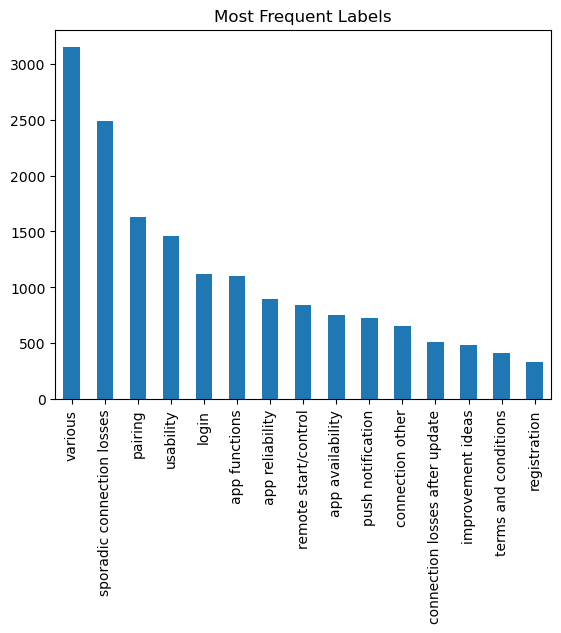

In [93]:
df_labels.sum().sort_values(ascending=False).head(15).plot(kind='bar', title='Most Frequent Labels')


In [94]:
# Step 1: Clean target columns
target_cols = ['Product Category 1', 'Product Category 2', 'Product Category 3', 'HC function', 'Product']

for col in target_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()
    df[col] = df[col].replace(['nan', '0.0', 'none', '', 'na'], np.nan)

# Step 2: Combine into multi-label list
def combine_targets(row):
    return [lbl for lbl in [row['Product Category 1'], row['Product Category 2'], row['Product Category 3'],
                            row['HC function'], row['Product']] if pd.notnull(lbl)]

df['multi_targets'] = df.apply(combine_targets, axis=1)

# Step 3: Drop rows with no labels
df = df[df['multi_targets'].map(len) > 0]


In [95]:
from collections import Counter

target_counts = Counter(df['multi_targets'].explode())
pd.Series(target_counts).sort_values(ascending=False).head(30)


dish care                     4288
laundry care                  1292
cooking                        946
oven                           510
pcp                            478
washer                         476
coffeemaker                    284
tab counter                    255
consumer products              177
cookit                         146
cooling                        114
dryer                           99
hob                             81
washer dryers                   63
refrigerator                    42
smart start                     37
hood                            29
brandify                        15
appliance usage statistics      11
delayed start                   10
smart watch                      9
roxxter                          9
program favorites                7
oven/microwave combi             6
singlekeyid                      6
detergent scanner                4
notification center              4
program assistance               3
detergent dosing    

In [96]:

mlb_targets = MultiLabelBinarizer()
target_matrix = mlb_targets.fit_transform(df['multi_targets'])

target_classes = mlb_targets.classes_
df_targets = pd.DataFrame(target_matrix, columns=target_classes, index=df.index)


## Overview of text data

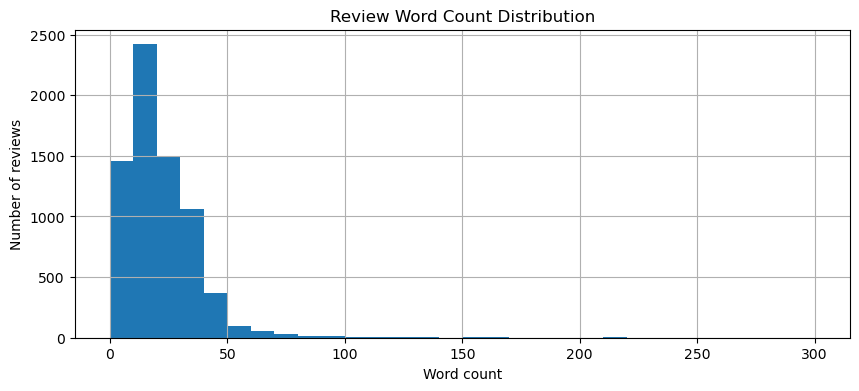

In [98]:
# Distribution of review lengths
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

df['word_count'].hist(bins=30, figsize=(10,4))
plt.title('Review Word Count Distribution')
plt.xlabel('Word count')
plt.ylabel('Number of reviews')
plt.show()


In [99]:
## Removing extremely short reviews (e.g., < 5 words)
df = df[df['word_count'] >= 5]


## Label frequency: df_labels 

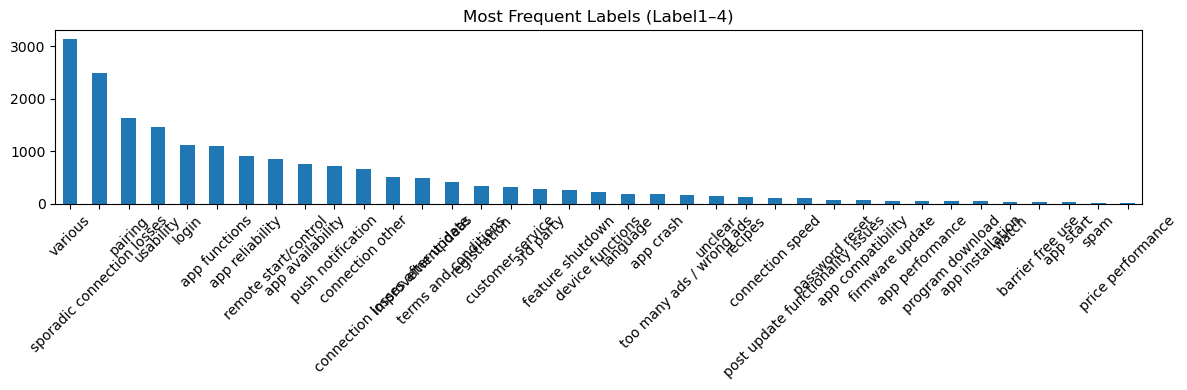

In [100]:
df_labels.sum().sort_values(ascending=False).plot(kind='bar', figsize=(12, 4), title='Most Frequent Labels (Label1–4)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Number of Labels per Review'}, xlabel='num_labels'>

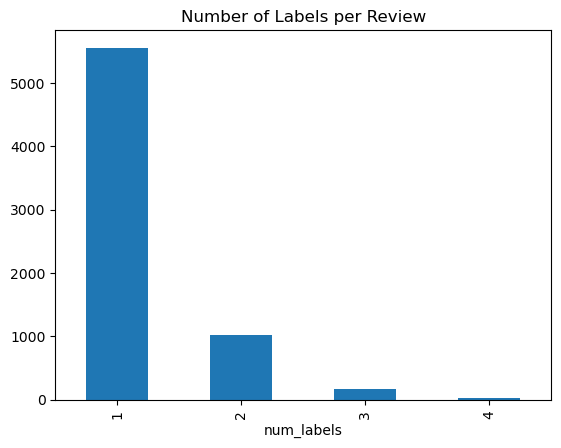

In [101]:
df['num_labels'] = df['multi_labels'].apply(len)
df['num_labels'].value_counts().sort_index().plot(kind='bar', title='Number of Labels per Review')


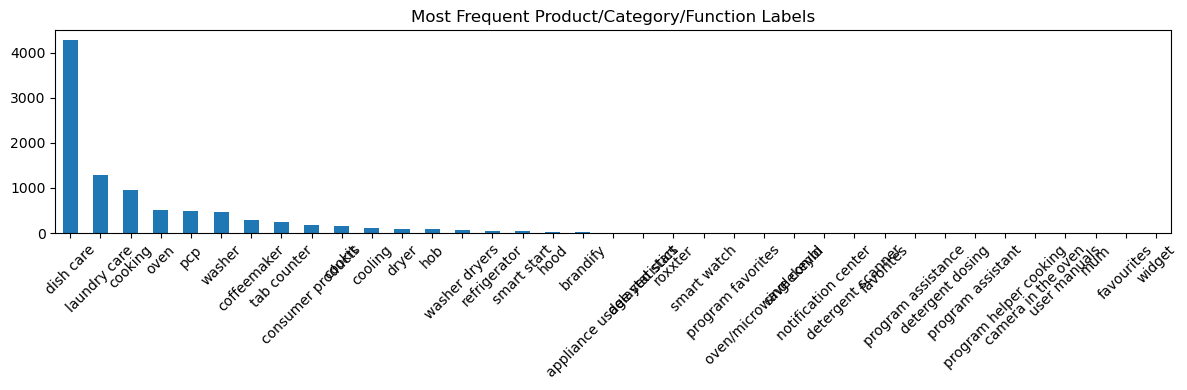

In [102]:
df_targets.sum().sort_values(ascending=False).plot(kind='bar', figsize=(12, 4), title='Most Frequent Product/Category/Function Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Number of Targets per Review'}, xlabel='num_targets'>

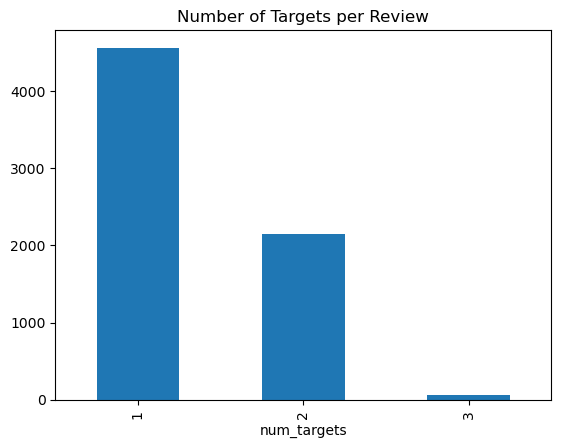

In [103]:
df['num_targets'] = df['multi_targets'].apply(len)
df['num_targets'].value_counts().sort_index().plot(kind='bar', title='Number of Targets per Review')


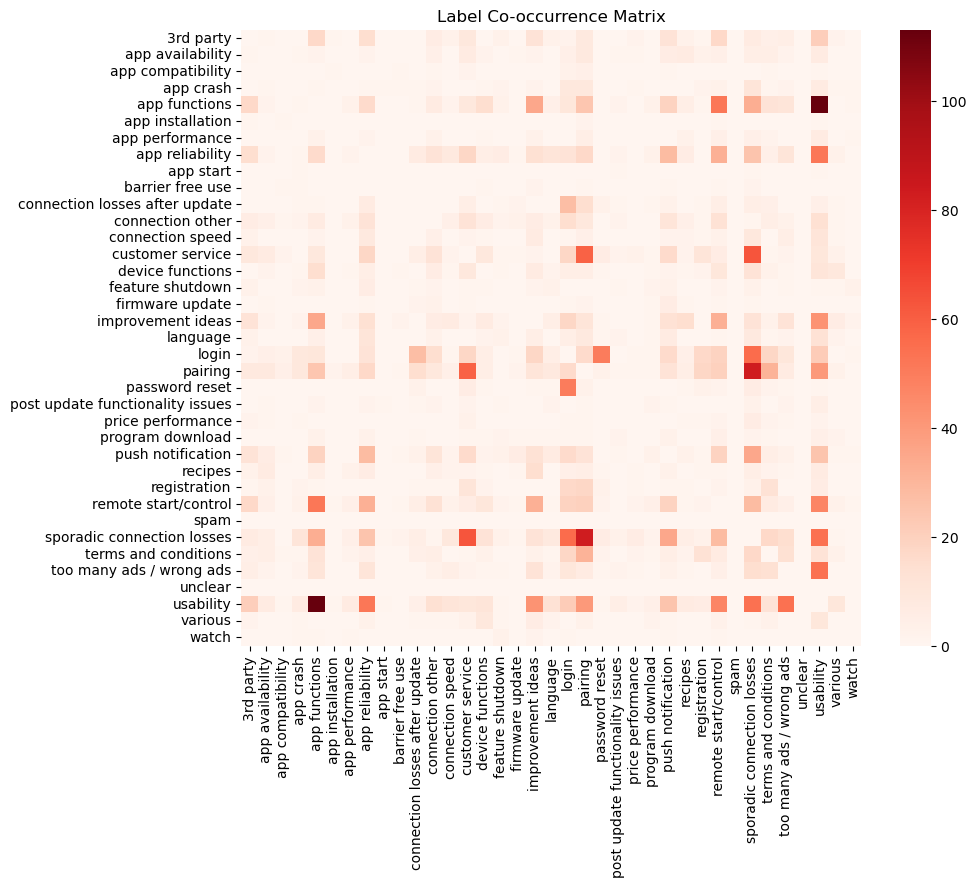

In [104]:
import seaborn as sns

co_matrix = df_labels.T.dot(df_labels)
np.fill_diagonal(co_matrix.values, 0)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=False, cmap='Reds')
plt.title("Label Co-occurrence Matrix")
plt.show()
